# Amazon Stock Prediction
authors: Scott Breitbach, Pushkar Chougule & Rachel Nelson

class: DSC630-T301 Predictive Analytics (2221-1)

source: https://towardsdatascience.com/predicting-future-stock-market-trends-with-python-machine-learning-2bf3f1633b3c

In [203]:
import sklearn.model_selection
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report



In [204]:
"""
Defining some constants for data mining
"""

NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'AMZN'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']


[*********************100%***********************]  1 of 1 completed
                open      high       low     close  Adj Close    volume
Date                                                                   
1997-05-15  2.437500  2.500000  1.927083  1.958333   1.958333  72156000
1997-05-16  1.968750  1.979167  1.708333  1.729167   1.729167  14700000
1997-05-19  1.760417  1.770833  1.625000  1.708333   1.708333   6106800
1997-05-20  1.729167  1.750000  1.635417  1.635417   1.635417   5467200
1997-05-21  1.635417  1.645833  1.375000  1.427083   1.427083  18853200


<AxesSubplot:xlabel='Date'>

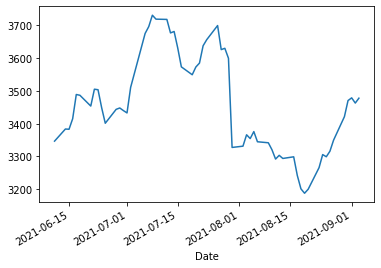

In [205]:
"""
Next we pull the historical data using yfinance
Rename the column names because finta uses the lowercase names
"""

start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(data.head())
data.to_csv('stockcsv.csv')
tmp = data.iloc[-60:]
tmp['close'].plot()

<AxesSubplot:xlabel='Date'>

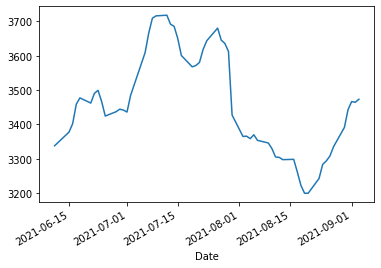

In [206]:
"""
Next we clean our data and perform feature engineering to create new technical indicator features that our
model can learn from
"""

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """

    return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['close'].plot()

In [207]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])

    return data

data = _get_indicator_data(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


In [208]:
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """

    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)

    return data

data = _produce_prediction(data, window=15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()


,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,
2021-08-09,31.764203,-44.091344,-6.853180,7.755404,2.298889e+09,70.742990,-333.948780,33.434579,-7.513256,4.097491e+09,-108.540129,-88.701800,1.052304,0.888191,0.987472,0.963101,0.959190,0.973717,0.666973,1.0
2021-08-10,30.480587,-49.976019,-15.477747,3.413925,2.297625e+09,69.875281,-315.593548,28.280778,-8.605684,4.095112e+09,-99.181282,-103.496739,1.053169,0.863165,0.982950,0.960181,0.957378,0.973971,0.722749,1.0
2021-08-11,28.638243,-55.957950,-23.573788,3.118477,2.296184e+09,69.671864,-330.294216,22.257290,-10.183282,4.092364e+09,-98.117505,-173.470350,1.102627,0.803928,0.976231,0.955197,0.953536,0.972225,0.858508,1.0
2021-08-12,28.553260,-60.095699,-30.878170,6.312919,2.296450e+09,69.636420,-308.275925,16.869660,-9.355956,4.089898e+09,-93.642027,-239.713657,1.152800,0.751296,0.976363,0.956838,0.956197,0.976471,0.800985,1.0
2021-08-13,28.023276,-63.177885,-37.338113,4.737888,2.296523e+09,67.685156,-129.749650,11.098003,-9.296936,4.087700e+09,-87.427473,-296.040163,1.212575,0.717060,0.974907,0.956892,0.957209,0.978680,0.749486,1.0


In [214]:
# split into train test sets
y_test = data['pred']
y_train = data['pred']
X_train = data.drop(columns=['pred'])
X_test = data.drop(columns=['pred'])

y_testa = data['pred']
y_traina = data['pred']

# Create training and test sets
y_trainb = [y_traina.iloc[0:1137]]
y_trainc = [y_traina.iloc[1725:2861]]
y_traind = [y_traina.iloc[3449:4585]]
y_traine = [y_traina.iloc[5173:6309]]

y_testb = [y_testa.iloc[1138:1724]]
y_testc = [y_testa.iloc[2862:3348]]
y_testd = [y_testa.iloc[4586:5172]]
y_teste = [y_testa.iloc[6310:6895]]


y_train = pd.DataFrame([y_trainb,y_trainc,y_traine,y_traine])
y_test = pd.DataFrame([y_testb,y_testc,y_testd,y_teste])

X_traina = data.drop(columns=['pred'])
X_testa = data.drop(columns=['pred'])

X_trainb = [X_traina.iloc[0:1137]]
X_trainc = [X_traina.iloc[1725:2861]]
X_traind = [X_traina.iloc[3449:4585]]
X_traine = [X_traina.iloc[5173:6309]]

X_testb = [X_testa.iloc[1138:1724]]
X_testc = [X_testa.iloc[2862:3348]]
X_testd = [X_testa.iloc[4586:5172]]
X_teste = [X_testa.iloc[6310:6895]]

X_train = pd.DataFrame([X_trainb,X_trainc,X_traine,X_traine])
X_test = pd.DataFrame([X_testb,X_testc,X_testd,X_teste])


In [215]:
def _train_random_forest(X_train, y_train, X_test, y_test):

    """
    Function that uses random forest classifier to train the model
    :return:
    """

    # Create a new random forest classifier
    rf = RandomForestClassifier()

    # Dictionary of all values we want to test for n_estimators
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}

    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=4)

    # Fit model to training data
    rf_gs.fit(X_train, y_train)

    # Save best model
    rf_best = rf_gs.best_estimator_

    # Check best n_estimators value
    print(rf_gs.best_params_)

    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))

    return rf_best

rf_model = _train_random_forest(X_train, y_train, X_test, y_test)

{'n_estimators': 130}
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2493
         1.0       1.00      1.00      1.00      3596

    accuracy                           1.00      6089
   macro avg       1.00      1.00      1.00      6089
weighted avg       1.00      1.00      1.00      6089

[[2493    0]
 [   0 3596]]


In [216]:
def _train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors': np.arange(1, 25)}

    # Use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=4)

    # Fit model to training data
    knn_gs.fit(X_train, y_train)

    # Save best model
    knn_best = knn_gs.best_estimator_

    # Check best n_neigbors value
    print(knn_gs.best_params_)

    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))

    return knn_best


knn_model = _train_KNN(X_train, y_train, X_test, y_test)


{'n_neighbors': 15}
              precision    recall  f1-score   support

         0.0       0.80      0.73      0.76      2493
         1.0       0.82      0.87      0.85      3596

    accuracy                           0.81      6089
   macro avg       0.81      0.80      0.81      6089
weighted avg       0.81      0.81      0.81      6089

[[1825  668]
 [ 463 3133]]
